## **i. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **ii. Import the libraries**
---

In [2]:
import cv2
import sys
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("Versions of key libraries")
print("---")
print("cv2:       ", cv2.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)


Versions of key libraries
---
cv2:        4.1.2
numpy:      1.19.4
matplotlib: 3.2.2


## **iii. Append /iss/vse/data/ in your python path**
---

In [3]:
sys.path.append('/content/gdrive/My Drive/iss/vse/data/')
print("All the system paths:")
sys.path

All the system paths:


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/iss/vse/data/']

## **iv. Change working directory to /iss/vse/data/**
---

In [4]:
os.chdir('/content/gdrive/My Drive/iss/vse/data/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/iss/vse/data'

## **v. Define `cv2plt` for image display**
---

In [5]:
def cv2plt(img):
    plt.figure(figsize=(7,7))        # To change the size of figure
    plt.axis('off')
    if np.size(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)  
    plt.show()

print(cv2plt)

<function cv2plt at 0x7f3bee437e18>


## **1. Basic preprocessing on image**
---
- Step 1: Read image of car
- Step 2: Convert colour image to gray-scale image
-Step 3: Display the images and check the shape of the numpy array

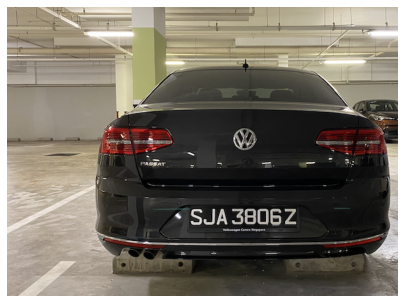

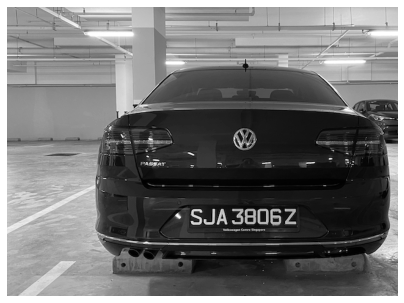

 The shape of 'cargray' is (474, 640)


In [6]:
                                    # Step 1
car      = cv2.imread('carplate01.png')

                                    # Step 2
                                        # We do not use the colour image to
                                        # locate carplate, instead gray-scale
                                        # image is used
cargray  = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)

                                    # Step 3
cv2plt(car)                             # Display the color image
cv2plt(cargray)                         # Display the gray-scale image
print(" The shape of 'cargray' is", cargray.shape)

## **2. Extract salient features in the image**
---
- Step 1: Apply Otsu thresholding on `cargray` and store the output as `lightest`.
- Step 2: Apply Canny edge detection on `lightest`, and check the minimum and maximum values in the numpy array

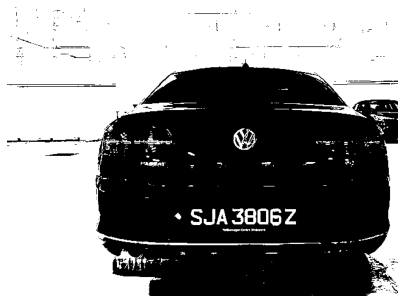

In [7]:
                              # Step 1
lightest  = cv2.threshold(cargray, 
                          0,                  # For Otsu thresholding, we set this to 0
                          255,                # Replacement value
			                    cv2.THRESH_OTSU)[1] # There are 2 outputs from Otsu thresholding,
                                              # we are only interested in the 2nd output
cv2plt(lightest)

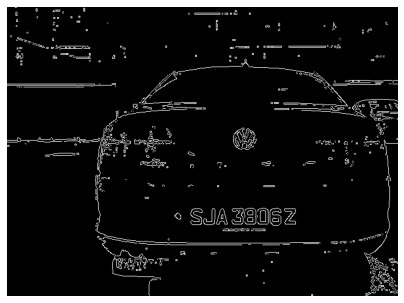

 The min and max value of 'edges' is  0 and 255


In [8]:
                            # Step 2
edges = cv2.Canny(lightest,
                  31,
                  127,
                  apertureSize=3)
cv2plt(edges)
print(" The min and max value of 'edges' is ", edges.min(), "and", edges.max())

## **3. Fuse carplate characters and remove noise**
---
- Step 1: Apply dilate and erode on `edges` to fuse the characters on the carplate into a single cohesive block. The output is stored as `bulk`
- Step 2: Apply dilate and erode again on `bulk` to remove unnecessary elements in the image

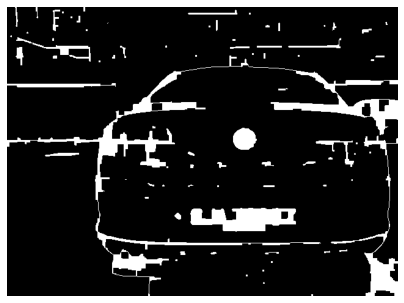

In [9]:
																# Step 1
bulk  = cv2.dilate(edges,None, iterations=4)
bulk  = cv2.erode(bulk,  None, iterations=4)

cv2plt(bulk)

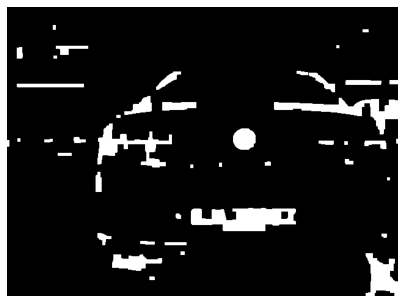

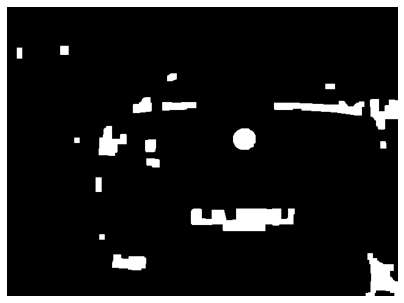

In [10]:
                                # Step 2
bulk  = cv2.erode(bulk,  None, iterations=2)
bulk  = cv2.dilate(bulk, None, iterations=2)
cv2plt(bulk)

bulk  = cv2.erode(bulk,  None, iterations=4)
bulk  = cv2.dilate(bulk, None, iterations=4)
cv2plt(bulk)

## **4. Get the contours and draw the first 5 contours with the largest area**
---
- Step 1: Use `.findContours()` to get all the contours in the image
- Step 2: Sort the contours based on the contour area, keep only the first 5 largest contour
- Step 3: Create a colour image `cargrayrgb` from `cargray`
- Step 4: Draw contours on the `cargrayrgb` and display the output

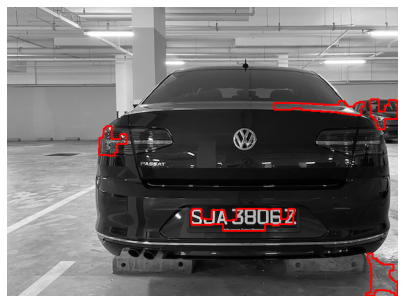

In [11]:
																	# Step 1
ctrs = cv2.findContours(bulk.copy(), 
                        cv2.RETR_EXTERNAL,
			                  cv2.CHAIN_APPROX_SIMPLE)
ctrs = ctrs[0]

																	# Step 2
ctrs = sorted(ctrs, key=cv2.contourArea, reverse=True)[:5]

																	# Step 3
cargrayrgb = cv2.merge((cargray,cargray,cargray))

																	# Step 4
cv2.drawContours(cargrayrgb, 
                 ctrs, 
								 -1, 
								 (0,0,255),
								 2)
cv2plt(cargrayrgb)

## **5. Locate the carplate and show the outputs**
---
- Step 1: For each contour, apply a bounding rectangle around the contours and calculate its aspect ratio (defined as width/height)
- Step 2: If the aspect ratio is between 4 and 5, the bounding rectangle is considered a carplate. Extract the region of interest and apply Otsu thresholding on the region of interest
- Step 3: Draw the bounding rectangle on the original colour image and show the extracted carplate numbers


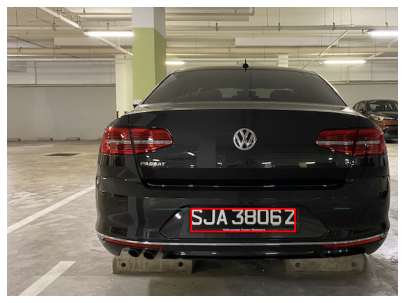

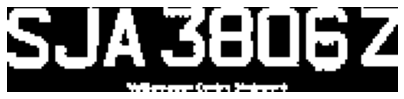

In [12]:
for c in ctrs:
                            # Step 1
  (x, y, w, h)  = cv2.boundingRect(c)
  aspr          = w/float(h)

                            # Step 2
  if aspr >= 4 and aspr <= 5:
    carPlate = cargray[y:y+h, x:x+w]
    carPlate = cv2.threshold(carPlate, 
                             0, 
                             255,
                             cv2.THRESH_OTSU)[1]
    break

                            # Step 3
cv2.rectangle(car,
              (x,y),
              (x+w,y+h),
              (0,0,255),
              2)
cv2plt(car)
cv2plt(carPlate)